# Preprocessing and EDA

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("NOAA_2025_EDA") \
    .getOrCreate()

base_path = "/home/alumno/reposirotio/Grupo3"
path_2025 = f"{base_path}/2025.tar/*"

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/05 11:03:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.types import *

schema = StructType([
    StructField("STATION", StringType(), True),
    StructField("DATE", StringType(), True),
    StructField("LATITUDE", DoubleType(), True),
    StructField("LONGITUDE", DoubleType(), True),
    StructField("ELEVATION", DoubleType(), True),
    StructField("NAME", StringType(), True),
    StructField("TEMP", DoubleType(), True),
    StructField("TEMP_ATTRIBUTES", StringType(), True),
    StructField("DEWP", DoubleType(), True),
    StructField("DEWP_ATTRIBUTES", StringType(), True),
    StructField("SLP", DoubleType(), True),
    StructField("SLP_ATTRIBUTES", StringType(), True),
    StructField("STP", DoubleType(), True),
    StructField("STP_ATTRIBUTES", StringType(), True),
    StructField("VISIB", DoubleType(), True),
    StructField("VISIB_ATTRIBUTES", StringType(), True),
    StructField("WDSP", DoubleType(), True),
    StructField("WDSP_ATTRIBUTES", StringType(), True),
    StructField("MXSPD", DoubleType(), True),
    StructField("GUST", DoubleType(), True),
    StructField("MAX", DoubleType(), True),
    StructField("MAX_ATTRIBUTES", StringType(), True),
    StructField("MIN", DoubleType(), True),
    StructField("MIN_ATTRIBUTES", StringType(), True),
    StructField("PRCP", DoubleType(), True),
    StructField("PRCP_ATTRIBUTES", StringType(), True),
    StructField("SNDP", DoubleType(), True),
    StructField("FRSHTT", StringType(), True),
])

In [3]:
df_2025 = spark.read \
    .option("header", "true") \
    .option("quote", '"') \
    .option("escape", '"') \
    .schema(schema) \
    .csv(path_2025)

26/01/05 11:03:18 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /home/alumno/reposirotio/Grupo3/2025.tar/*.
java.io.FileNotFoundException: File /home/alumno/reposirotio/Grupo3/2025.tar/* does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.ap

In [4]:
row_count = df_2025.count()
print(f"Number of rows in 2025 dataset: {row_count}")

[Stage 1:======================================================>(363 + 4) / 369]

Number of rows in 2025 dataset: 5068279


In [5]:
df_2025.printSchema()
df_2025.show(5)

26/01/05 11:04:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- TEMP_ATTRIBUTES: string (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- DEWP_ATTRIBUTES: string (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: string (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: string (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- VISIB_ATTRIBUTES: string (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- WDSP_ATTRIBUTES: string (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: double (nullable = true)
 |-- MIN_ATTRIBUTES: string (nullable = true)
 |-- PRCP: double (nullable = t

26/01/05 11:04:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, TEMP_ATTRIBUTES, DEWP, DEWP_ATTRIBUTES, SLP, SLP_ATTRIBUTES, STP, STP_ATTRIBUTES, VISIB, VISIB_ATTRIBUTES, WDSP, WDSP_ATTRIBUTES, MXSPD, GUST, MAX, MAX_ATTRIBUTES, MIN, MIN_ATTRIBUTES, PRCP, PRCP_ATTRIBUTES, SNDP, FRSHTT
 Schema: STATION, DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, TEMP_ATTRIBUTES, DEWP, DEWP_ATTRIBUTES, SLP, 

## Missing values

In [6]:
from pyspark.sql.functions import col, when, count, trim

numeric_cols = [
    "LATITUDE","LONGITUDE","ELEVATION","TEMP","DEWP","SLP","STP",
    "VISIB","WDSP","MXSPD","GUST","MAX","MIN","PRCP","SNDP"
]

all_cols = df_2025.columns

missing_exprs = []

for c in all_cols:
    if c in numeric_cols:
        # Numeric missing: 999.9 / 9999.9 / null
        expr = count(when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), c)).alias(c)
    else:
        # String missing: null, empty, or only spaces
        expr = count(when((col(c).isNull()) | (trim(col(c)) == ""), c)).alias(c)
    missing_exprs.append(expr)

missing_counts = df_2025.select(*missing_exprs)
missing_counts.show()

26/01/05 11:04:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, TEMP_ATTRIBUTES, DEWP, DEWP_ATTRIBUTES, SLP, SLP_ATTRIBUTES, STP, STP_ATTRIBUTES, VISIB, VISIB_ATTRIBUTES, WDSP, WDSP_ATTRIBUTES, MXSPD, GUST, MAX, MAX_ATTRIBUTES, MIN, MIN_ATTRIBUTES, PRCP, PRCP_ATTRIBUTES, SNDP, FRSHTT
 Schema: STATION, DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, TEMP_ATTRIBUTES, DEWP, DEWP_ATTRIBUTES, SLP, 

+-------+----+--------+---------+---------+-----+-----+---------------+------+---------------+-------+--------------+-------+--------------+-------+----------------+------+---------------+------+-------+-----+--------------+-----+--------------+-----+---------------+-------+------+
|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION| NAME| TEMP|TEMP_ATTRIBUTES|  DEWP|DEWP_ATTRIBUTES|    SLP|SLP_ATTRIBUTES|    STP|STP_ATTRIBUTES|  VISIB|VISIB_ATTRIBUTES|  WDSP|WDSP_ATTRIBUTES| MXSPD|   GUST|  MAX|MAX_ATTRIBUTES|  MIN|MIN_ATTRIBUTES| PRCP|PRCP_ATTRIBUTES|   SNDP|FRSHTT|
+-------+----+--------+---------+---------+-----+-----+---------------+------+---------------+-------+--------------+-------+--------------+-------+----------------+------+---------------+------+-------+-----+--------------+-----+--------------+-----+---------------+-------+------+
|      0|   0|   28159|    28159|    28589|16504|11655|              0|241995|              0|1714435|             0|1446373|             0|1330683|   

### SNDP values: boundary snow

In [7]:
from pyspark.sql.functions import col

# Consider missing SNDP as: null, 999.9, 9999.9
missing_sndp = df_2025.filter(
    (col("SNDP").isNull()) | (col("SNDP") == 999.9) | (col("SNDP") == 9999.9)
)

In [8]:
missing_sndp.select(
    "TEMP", "MIN", "MAX"
).describe().show()

[Stage 8:======================================================>(368 + 1) / 369]

+-------+------------------+------------------+------------------+
|summary|              TEMP|               MIN|               MAX|
+-------+------------------+------------------+------------------+
|  count|           4716302|           4716302|           4716302|
|   mean|60.071913376200314|58.574181339532025| 75.71713872436432|
| stddev|20.197027428424366|282.86965388251764|236.78718592638987|
|    min|            -104.4|            -108.0|            -101.7|
|    max|             110.0|            9999.9|            9999.9|
+-------+------------------+------------------+------------------+



In [9]:
from pyspark.sql.functions import col, when, count

# Filter rows where SNDP is missing (NaN, 999.9, 9999.9)
missing_sndp = df_2025.filter(
    (col("SNDP").isNull()) | (col("SNDP") == 999.9) | (col("SNDP") == 9999.9)
)

# Create categories based on MIN temperature
boundary_f = 5 * 9/5 + 32  # 5°C in Fahrenheit ≈ 41°F

category_counts = missing_sndp.withColumn(
    "snow_likely",
    when(col("MIN") > boundary_f, "snow_unlikely").otherwise("snow_possible")
).groupBy("snow_likely").count()

category_counts.show()

[Stage 11:=====================================================>(368 + 1) / 369]

+-------------+-------+
|  snow_likely|  count|
+-------------+-------+
|snow_possible|1453235|
|snow_unlikely|3274722|
+-------------+-------+



In [10]:
from pyspark.sql.functions import when, col

# Boundary: 5°C in Fahrenheit
boundary_f = 5 * 9/5 + 32  # 41°F

df_2025_clean = df_2025.withColumn(
    "SNDP",
    when(
        ((col("SNDP").isNull()) | (col("SNDP") == 999.9) | (col("SNDP") == 9999.9)) & (col("MIN") > boundary_f),
        0
    ).otherwise(col("SNDP"))
)

# Drop rows where snow is possible (MIN <= 5°C & SNDP missing)
df_2025_clean = df_2025_clean.filter(
    ~(((col("SNDP").isNull()) | (col("SNDP") == 999.9) | (col("SNDP") == 9999.9)) & (col("MIN") <= boundary_f))
)

# Count remaining rows
print("Rows after cleaning SNDP:", df_2025_clean.count())

[Stage 14:====================================================> (360 + 4) / 369]

Rows after cleaning SNDP: 3615044


### Clean other rows

In [11]:
from pyspark.sql.functions import col, when, count, trim

numeric_cols = [
    "LATITUDE","LONGITUDE","ELEVATION","TEMP","DEWP","SLP","STP",
    "VISIB","WDSP","MXSPD","GUST","MAX","MIN","PRCP","SNDP"
]

all_cols = df_2025_clean.columns

missing_exprs = []

for c in all_cols:
    if c in numeric_cols:
        # Numeric missing: 999.9 / 9999.9 / null
        expr = count(when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), c)).alias(c)
    else:
        # String missing: null, empty, or only spaces
        expr = count(when((col(c).isNull()) | (trim(col(c)) == ""), c)).alias(c)
    missing_exprs.append(expr)

missing_counts = df_2025_clean.select(*missing_exprs)
missing_counts.show()

26/01/05 11:05:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, TEMP_ATTRIBUTES, DEWP, DEWP_ATTRIBUTES, SLP, SLP_ATTRIBUTES, STP, STP_ATTRIBUTES, VISIB, VISIB_ATTRIBUTES, WDSP, WDSP_ATTRIBUTES, MXSPD, GUST, MAX, MAX_ATTRIBUTES, MIN, MIN_ATTRIBUTES, PRCP, PRCP_ATTRIBUTES, SNDP, FRSHTT
 Schema: STATION, DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, TEMP_ATTRIBUTES, DEWP, DEWP_ATTRIBUTES, SLP, 

+-------+----+--------+---------+---------+-----+----+---------------+------+---------------+-------+--------------+-------+--------------+------+----------------+------+---------------+------+-------+----+--------------+----+--------------+----+---------------+----+------+
|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION| NAME|TEMP|TEMP_ATTRIBUTES|  DEWP|DEWP_ATTRIBUTES|    SLP|SLP_ATTRIBUTES|    STP|STP_ATTRIBUTES| VISIB|VISIB_ATTRIBUTES|  WDSP|WDSP_ATTRIBUTES| MXSPD|   GUST| MAX|MAX_ATTRIBUTES| MIN|MIN_ATTRIBUTES|PRCP|PRCP_ATTRIBUTES|SNDP|FRSHTT|
+-------+----+--------+---------+---------+-----+----+---------------+------+---------------+-------+--------------+-------+--------------+------+----------------+------+---------------+------+-------+----+--------------+----+--------------+----+---------------+----+------+
|      0|   0|   10174|    10174|    10174|10174|   0|              0|154730|              0|1171984|             0|1034000|             0|924108|               0|111208|     

### Drop columns attributes and gust

In [12]:
cols_to_drop = [
    "TEMP_ATTRIBUTES","DEWP_ATTRIBUTES","SLP_ATTRIBUTES","STP_ATTRIBUTES",
    "VISIB_ATTRIBUTES","WDSP_ATTRIBUTES", "GUST","MAX_ATTRIBUTES",
    "MIN_ATTRIBUTES","PRCP_ATTRIBUTES"]

df_2025_clean = df_2025_clean.drop(*cols_to_drop)

In [13]:
df_2025_clean.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MIN: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNDP: double (nullable = true)
 |-- FRSHTT: string (nullable = true)



In [14]:
from pyspark.sql.functions import col, when, count, trim

numeric_cols = [
    "LATITUDE","LONGITUDE","ELEVATION","TEMP","DEWP","SLP","STP",
    "VISIB","WDSP","MXSPD","MAX","MIN","PRCP","SNDP"
]

all_cols = df_2025_clean.columns

missing_exprs = []

for c in all_cols:
    if c in numeric_cols:
        # Numeric missing: 999.9 / 9999.9 / null
        expr = count(when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), c)).alias(c)
    else:
        # String missing: null, empty, or only spaces
        expr = count(when((col(c).isNull()) | (trim(col(c)) == ""), c)).alias(c)
    missing_exprs.append(expr)

missing_counts = df_2025_clean.select(*missing_exprs)
missing_counts.show()

26/01/05 11:05:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, DEWP, SLP, STP, VISIB, WDSP, MXSPD, MAX, MIN, PRCP, SNDP, FRSHTT
 Schema: STATION, DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, DEWP, SLP, STP, VISIB, WDSP, MXSPD, MAX, MIN, PRCP, SNDP, FRSHTT
Expected: STATION but found: 01002099999.csv                                                                                     0100644

+-------+----+--------+---------+---------+-----+----+------+-------+-------+------+------+------+----+----+----+----+------+
|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION| NAME|TEMP|  DEWP|    SLP|    STP| VISIB|  WDSP| MXSPD| MAX| MIN|PRCP|SNDP|FRSHTT|
+-------+----+--------+---------+---------+-----+----+------+-------+-------+------+------+------+----+----+----+----+------+
|      0|   0|   10174|    10174|    10174|10174|   0|154730|1171984|1034000|924108|111208|142032|1414|3968|   0|   0|     0|
+-------+----+--------+---------+---------+-----+----+------+-------+-------+------+------+------+----+----+----+----+------+



### Drop samples without latitude, longitude, elevation

In [15]:
# Define critical columns
critical_cols = ["LATITUDE", "LONGITUDE", "ELEVATION", "NAME"]

# Drop rows where any of these are missing
df_2025_clean = df_2025_clean.na.drop(subset=critical_cols)

# Check remaining rows
print("Rows after dropping critical missing values:", df_2025_clean.count())

[Stage 23:===================================================>  (351 + 4) / 369]

Rows after dropping critical missing values: 3604870


In [16]:
from pyspark.sql.functions import col, when, count, trim

numeric_cols = [
    "LATITUDE","LONGITUDE","ELEVATION","TEMP","DEWP","SLP","STP",
    "VISIB","WDSP","MXSPD","MAX","MIN","PRCP","SNDP"
]

all_cols = df_2025_clean.columns

missing_exprs = []

for c in all_cols:
    if c in numeric_cols:
        # Numeric missing: 999.9 / 9999.9 / null
        expr = count(when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), c)).alias(c)
    else:
        # String missing: null, empty, or only spaces
        expr = count(when((col(c).isNull()) | (trim(col(c)) == ""), c)).alias(c)
    missing_exprs.append(expr)

missing_counts = df_2025_clean.select(*missing_exprs)
missing_counts.show()

26/01/05 11:06:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, DEWP, SLP, STP, VISIB, WDSP, MXSPD, MAX, MIN, PRCP, SNDP, FRSHTT
 Schema: STATION, DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, TEMP, DEWP, SLP, STP, VISIB, WDSP, MXSPD, MAX, MIN, PRCP, SNDP, FRSHTT
Expected: STATION but found: 01002099999.csv                                                                                     0100644

+-------+----+--------+---------+---------+----+----+------+-------+-------+------+------+------+----+----+----+----+------+
|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION|NAME|TEMP|  DEWP|    SLP|    STP| VISIB|  WDSP| MXSPD| MAX| MIN|PRCP|SNDP|FRSHTT|
+-------+----+--------+---------+---------+----+----+------+-------+-------+------+------+------+----+----+----+----+------+
|      0|   0|       0|        0|        0|   0|   0|153830|1162028|1033124|922968|110316|141138|1412|3964|   0|   0|     0|
+-------+----+--------+---------+---------+----+----+------+-------+-------+------+------+------+----+----+----+----+------+



### Missing values "DEWP","SLP","STP","VISIB","WDSP","MXSPD"

In [17]:
from functools import reduce
from pyspark.sql.functions import col

missing_cols = ["DEWP","SLP","STP","VISIB","WDSP","MXSPD"]

# For each column, missing is either null OR 999.9 OR 9999.9
missing_condition = reduce(
    lambda a, b: a | b,
    [
        (col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9)
        for c in missing_cols
    ]
)

# Filter rows where any of these is missing
missing_rows = df_2025_clean.filter(missing_condition)

# Count total missing rows
total_missing_count = missing_rows.count()

# Count how many have snow > 0
snow_positive_count = missing_rows.filter(col("SNDP") > 0).count()

print(f"Total rows with missing measurements: {total_missing_count}")
print(f"Among them, rows with SNDP > 0: {snow_positive_count}")

[Stage 32:====================================================> (360 + 4) / 369]

Total rows with missing measurements: 2073178
Among them, rows with SNDP > 0: 146716


#### Grid-based imputation (spatial binning)

1. Define a grid: round lat/lon to some precision, e.g., 1° or 0.5°. This groups nearby stations.
2. Compute the mean per grid cell for each numeric column, ignoring missing values (999.9 / 9999.9 / null).
3. Impute missing values with the grid mean instead of station mean.

This is much faster than pairwise distances and gives a reasonable approximation of nearby station values.

In [18]:
from pyspark.sql import Window
from pyspark.sql.functions import col, when, avg, round, count

# Columns to impute
numeric_cols = ["DEWP","SLP","STP","VISIB","WDSP","MXSPD"]

# ---------------------
# Station-wise mean
# ---------------------
df_station = df_2025_clean

for c in numeric_cols:
    window = Window.partitionBy("STATION")
    df_station = df_station.withColumn(
        c,
        when(
            (col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9),
            avg(
                when((col(c) != 999.9) & (col(c) != 9999.9) & col(c).isNotNull(), col(c))
            ).over(window)
        ).otherwise(col(c))
    )

# ---------------------
# Grid-wise mean for remaining missing
# ---------------------
# Define grid precision (2 degrees)
grid_precision = 2.0
df_grid = df_station.withColumn("LAT_GRID", round(col("LATITUDE") / grid_precision) * grid_precision) \
                    .withColumn("LON_GRID", round(col("LONGITUDE") / grid_precision) * grid_precision)

for c in numeric_cols:
    # Grid mean ignoring missing codes
    grid_mean = df_grid.groupBy("LAT_GRID", "LON_GRID").agg(
        avg(
            when((col(c) != 999.9) & (col(c) != 9999.9) & col(c).isNotNull(), col(c))
        ).alias(f"{c}_grid_mean")
    )
    
    df_grid = df_grid.join(grid_mean, on=["LAT_GRID", "LON_GRID"], how="left")
    
    # Impute missing values using grid mean
    df_grid = df_grid.withColumn(
        c,
        when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), col(f"{c}_grid_mean"))
        .otherwise(col(c))
    ).drop(f"{c}_grid_mean")

In [19]:
from pyspark.sql.functions import col, when, count, trim

numeric_cols = [
    "LATITUDE","LONGITUDE","ELEVATION","TEMP","DEWP","SLP","STP",
    "VISIB","WDSP","MXSPD","MAX","MIN","PRCP","SNDP"
]

all_cols = df_grid.columns

missing_exprs = []

for c in all_cols:
    if c in numeric_cols:
        # Numeric missing: 999.9 / 9999.9 / null
        expr = count(when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), c)).alias(c)
    else:
        # String missing: null, empty, or only spaces
        expr = count(when((col(c).isNull()) | (trim(col(c)) == ""), c)).alias(c)
    missing_exprs.append(expr)

missing_counts = df_grid.select(*missing_exprs)
missing_counts.show()

26/01/05 11:07:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", LATITUDE, LONGITUDE, ELEVATION, NAME, VISIB, MIN, SNDP
 Schema: STATION, LATITUDE, LONGITUDE, ELEVATION, NAME, VISIB, MIN, SNDP
Expected: STATION but found: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                      

+--------+--------+-------+----+--------+---------+---------+----+----+----+------+------+------+----+-----+----+----+----+----+------+
|LAT_GRID|LON_GRID|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION|NAME|TEMP|DEWP|   SLP|   STP| VISIB|WDSP|MXSPD| MAX| MIN|PRCP|SNDP|FRSHTT|
+--------+--------+-------+----+--------+---------+---------+----+----+----+------+------+------+----+-----+----+----+----+----+------+
|       0|       0|      0|   0|       0|        0|        0|   0|   0|8240|163216|170564|186520|3834| 5308|1412|3964|   0|   0|     0|
+--------+--------+-------+----+--------+---------+---------+----+----+----+------+------+------+----+-----+----+----+----+----+------+



### Final imputation 

In [20]:
from pyspark.sql.functions import col

# Drop any row that has a missing value in any column
df_2025_final = df_grid.dropna()

# Columns to check for placeholder missing values
numeric_cols = ["TEMP","DEWP","SLP","STP","VISIB","WDSP","MXSPD","MAX","MIN","PRCP","SNDP"]

# Drop rows with 999.9 or 9999.9 in any numeric column
for c in numeric_cols:
    df_2025_final = df_2025_final.filter(~col(c).isin([999.9, 9999.9]))

# Check the number of remaining rows
print(f"Total rows after dropping all missing values: {df_2025_final.count()}")

26/01/05 11:09:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", LATITUDE, LONGITUDE, ELEVATION, NAME, SLP, MIN, SNDP
 Schema: STATION, LATITUDE, LONGITUDE, ELEVATION, NAME, SLP, MIN, SNDP
Expected: STATION but found: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                          

Total rows after dropping all missing values: 3158766


In [21]:
from pyspark.sql.functions import col, when, count, trim

numeric_cols = [
    "LATITUDE","LONGITUDE","ELEVATION","TEMP","DEWP","SLP","STP",
    "VISIB","WDSP","MXSPD","MAX","MIN","PRCP","SNDP"
]

all_cols = df_2025_final.columns

missing_exprs = []

for c in all_cols:
    if c in numeric_cols:
        # Numeric missing: 999.9 / 9999.9 / null
        expr = count(when((col(c).isNull()) | (col(c) == 999.9) | (col(c) == 9999.9), c)).alias(c)
    else:
        # String missing: null, empty, or only spaces
        expr = count(when((col(c).isNull()) | (trim(col(c)) == ""), c)).alias(c)
    missing_exprs.append(expr)

missing_counts = df_2025_final.select(*missing_exprs)
missing_counts.show()

26/01/05 11:11:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", LATITUDE, LONGITUDE, ELEVATION, NAME, VISIB, MIN, SNDP
 Schema: STATION, LATITUDE, LONGITUDE, ELEVATION, NAME, VISIB, MIN, SNDP
Expected: STATION but found: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                      

+--------+--------+-------+----+--------+---------+---------+----+----+----+---+---+-----+----+-----+---+---+----+----+------+
|LAT_GRID|LON_GRID|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION|NAME|TEMP|DEWP|SLP|STP|VISIB|WDSP|MXSPD|MAX|MIN|PRCP|SNDP|FRSHTT|
+--------+--------+-------+----+--------+---------+---------+----+----+----+---+---+-----+----+-----+---+---+----+----+------+
|       0|       0|      0|   0|       0|        0|        0|   0|   0|   0|  0|  0|    0|   0|    0|  0|  0|   0|   0|     0|
+--------+--------+-------+----+--------+---------+---------+----+----+----+---+---+-----+----+-----+---+---+----+----+------+



In [22]:
df_2025_final = df_2025_final.drop("LAT_GRID", "LON_GRID")

## Data transformations

DATE – Observation date (MM/DD/YYYY). -> Change to datetime type

NAME – Name of the station, airport, or military base. -> Extract country

TEMP – Average daily air temperature (°F, to 0.1). -> To celsius

DEWP – Average daily dew point temperature (°F, to 0.1). -> To celsius

VISIB – Mean daily visibility (miles, to 0.1). -> To km

WDSP – Mean daily wind speed (knots, to 0.1). -> To km/h

MXSPD – Maximum sustained wind speed for the day (knots). -> To km/h

MAX – Highest temperature reported during the day (°F, to 0.1). -> To celsius

MIN – Lowest temperature reported during the day (°F, to 0.1). -> To celsius

PRCP – Total daily precipitation (inches, to 0.01), may span non-midnight periods. -> To l/m^2

SNDP – Snow depth on the ground (inches, to 0.1), last report of the day. -> To cm

In [23]:
from pyspark.sql.functions import col, to_date, split, size

# Apply all transformations in one chain
df_transformed = (
    df_2025_final
    # Convert DATE to datetime
    .withColumn("DATE", to_date(col("DATE"), "yyyy-MM-dd"))
    
    # Extract country from NAME (last word)
    .withColumn("COUNTRY", split(col("NAME"), ", ")[size(split(col("NAME"), ", ")) - 1])
    
    # Convert temperatures from °F to °C
    .withColumn("TEMP", (col("TEMP") - 32) * 5/9)
    .withColumn("DEWP", (col("DEWP") - 32) * 5/9)
    .withColumn("MAX", (col("MAX") - 32) * 5/9)
    .withColumn("MIN", (col("MIN") - 32) * 5/9)
    
    # Convert visibility from miles to km
    .withColumn("VISIB", col("VISIB") * 1.60934)
    
    # Convert wind speed from knots to km/h
    .withColumn("WDSP", col("WDSP") * 1.852)
    .withColumn("MXSPD", col("MXSPD") * 1.852)
    
    # Convert precipitation from inches to liters/m^2
    .withColumn("PRCP", col("PRCP") * 25.4)
    
    # Convert snow depth from inches to cm
    .withColumn("SNDP", col("SNDP") * 2.54)
)

In [24]:
df_transformed.show(5)

26/01/05 11:13:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", LATITUDE, LONGITUDE, ELEVATION, NAME, DEWP, MIN, SNDP
 Schema: STATION, LATITUDE, LONGITUDE, ELEVATION, NAME, DEWP, MIN, SNDP
Expected: STATION but found: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                        

+-----------+----------+--------+---------+---------+---------+-------------------+-------------------+-----+-----+------------------+------------------+------------------+-------------------+------------------+-----+------------------+------+-------+
|    STATION|      DATE|LATITUDE|LONGITUDE|ELEVATION|     NAME|               TEMP|               DEWP|  SLP|  STP|             VISIB|              WDSP|             MXSPD|                MAX|               MIN| PRCP|              SNDP|FRSHTT|COUNTRY|
+-----------+----------+--------+---------+---------+---------+-------------------+-------------------+-----+-----+------------------+------------------+------------------+-------------------+------------------+-----+------------------+------+-------+
|01082099999|2025-01-01|   69.15|    29.25|     56.0|NYRUD, NO|-11.555555555555555|-13.222222222222221|985.8|978.8|18.283796442105263|14.280977777777782|24.780938389527158| -4.500000000000001|             -20.5|0.254|41.910000000000004|000000| 

In [25]:
df_transformed.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MIN: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNDP: double (nullable = true)
 |-- FRSHTT: string (nullable = true)
 |-- COUNTRY: string (nullable = false)



## One-Hot encoding

In [26]:
from pyspark.sql.functions import col, substring

weather_cols = ["is_Fog", "is_Rain", "is_Snow", "is_Hail", "is_Thunder", "is_Tornado"]

# Create new columns using select
df_encoded = df_transformed.select(
    "*",  # Keep all existing columns
    *[substring(col("FRSHTT"), i + 1, 1).cast("int").alias(w) for i, w in enumerate(weather_cols)]
).drop("FRSHTT")  # Drop original column


In [27]:
df_encoded.show(5)

26/01/05 11:15:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", LATITUDE, LONGITUDE, ELEVATION, NAME, MXSPD, MIN, SNDP
 Schema: STATION, LATITUDE, LONGITUDE, ELEVATION, NAME, MXSPD, MIN, SNDP
Expected: STATION but found: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                      

+-----------+----------+--------+---------+---------+---------+-------------------+-------------------+-----+-----+------------------+------------------+------------------+-------------------+------------------+-----+------------------+-------+------+-------+-------+-------+----------+----------+
|    STATION|      DATE|LATITUDE|LONGITUDE|ELEVATION|     NAME|               TEMP|               DEWP|  SLP|  STP|             VISIB|              WDSP|             MXSPD|                MAX|               MIN| PRCP|              SNDP|COUNTRY|is_Fog|is_Rain|is_Snow|is_Hail|is_Thunder|is_Tornado|
+-----------+----------+--------+---------+---------+---------+-------------------+-------------------+-----+-----+------------------+------------------+------------------+-------------------+------------------+-----+------------------+-------+------+-------+-------+-------+----------+----------+
|01082099999|2025-01-01|   69.15|    29.25|     56.0|NYRUD, NO|-11.555555555555555|-13.222222222222221|985

## Correlation

Calculating correlation matrix...


26/01/05 11:18:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                                                    ustar 00                                                                0000000 0000000                                                                                                                                                                        "STATION", LATITUDE, LONGITUDE, ELEVATION, NAME, DEWP, MIN, SNDP
 Schema: STATION, LATITUDE, LONGITUDE, ELEVATION, NAME, DEWP, MIN, SNDP
Expected: STATION but found: 01002099999.csv                                                                                     0100644 0000000 0000000 00000106754 15054202506 011515  0                                                                        


Correlation Matrix (Top 5 rows):
           LATITUDE  LONGITUDE  ELEVATION      TEMP      DEWP
LATITUDE   1.000000  -0.157337   0.022239 -0.381177 -0.389259
LONGITUDE -0.157337   1.000000  -0.066285 -0.040790 -0.028293
ELEVATION  0.022239  -0.066285   1.000000 -0.082170 -0.229170
TEMP      -0.381177  -0.040790  -0.082170  1.000000  0.860485
DEWP      -0.389259  -0.028293  -0.229170  0.860485  1.000000


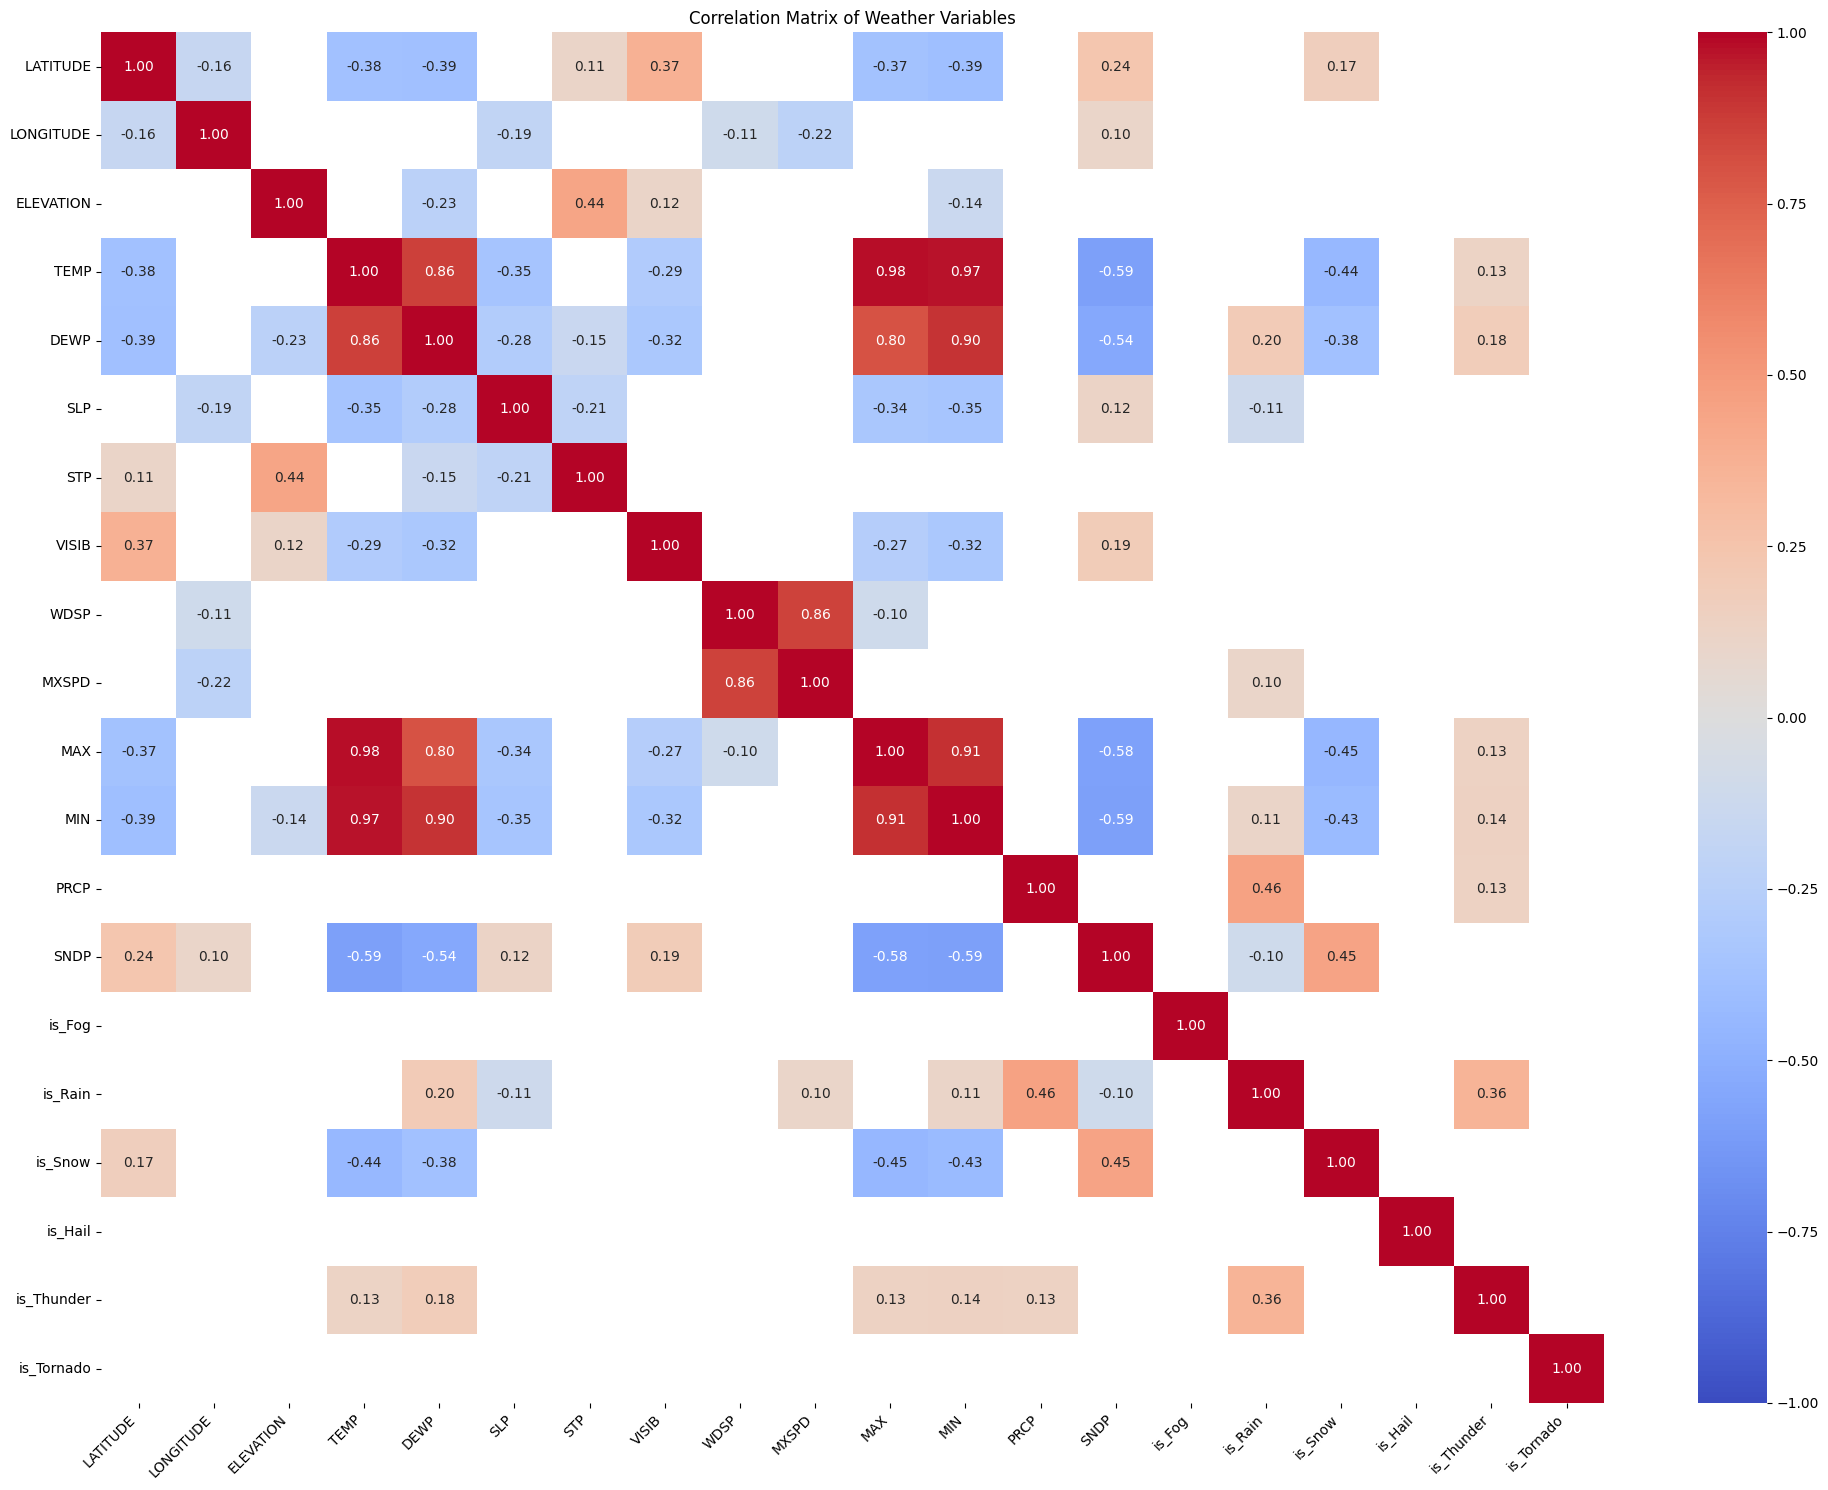

In [29]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the numerical columns to analyze
#    (We exclude String columns like STATION, DATE, NAME, COUNTRY)
numeric_cols = [
    "LATITUDE", "LONGITUDE", "ELEVATION", 
    "TEMP", "DEWP", "SLP", "STP", "VISIB", "WDSP", "MXSPD", 
    "MAX", "MIN", "PRCP", "SNDP",
    "is_Fog", "is_Rain", "is_Snow", "is_Hail", "is_Thunder", "is_Tornado"
]

# 2. Prepare the data
#    VectorAssembler requires no null values, so we drop rows with NaNs in these columns
df_for_corr = df_encoded.select(numeric_cols).dropna()

# 3. Create the feature vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df_for_corr)

# 4. Calculate Pearson Correlation
print("Calculating correlation matrix...")
pearson_corr = Correlation.corr(df_vector, "features", "pearson").collect()[0][0]

# 5. Convert to Pandas DataFrame for better readability
rows = pearson_corr.toArray().tolist()
corr_matrix = pd.DataFrame(rows, columns=numeric_cols, index=numeric_cols)

# 6. Display the Matrix (Text)
print("\nCorrelation Matrix (Top 5 rows):")
print(corr_matrix.iloc[:5, :5])  # Show a small preview

# 7. Visualize with a Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    mask=corr_matrix.abs() < 0.1  # Optional: hide weak correlations to reduce noise
)
plt.title("Correlation Matrix of Weather Variables")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()